In [2]:
# ------------------------------------------------------------
# Step 1: Import Required Libraries
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully.")


✅ Libraries loaded successfully.


In [3]:
# ------------------------------
# Step 2: Load Dataset
# ------------------------------
df = pd.read_csv("dataset/earthquake_preprocessed_week2.csv")
print("✅ Dataset loaded, shape:", df.shape)

# Check original impact level distribution
print("\nImpact Level distribution:\n", df['Impact_Level'].value_counts())

✅ Dataset loaded, shape: (1992, 17)

Impact Level distribution:
 Impact_Level
Low       1348
Medium     580
High        64
Name: count, dtype: int64


In [7]:
# ------------------------------
# Step 3: Encode Features & Target
# ------------------------------

import os
# Encode Soil_Type as numeric for ML
soil_encoder = LabelEncoder()
df['Soil_Type_Encoded'] = soil_encoder.fit_transform(df['Soil_Type'])

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(df['Impact_Level'])

# Save soil types for Streamlit dropdown
soil_type_names = df['Soil_Type'].unique().tolist()
os.makedirs("models", exist_ok=True)
joblib.dump(soil_type_names, "models/soil_type_names.pkl")

['models/soil_type_names.pkl']

In [8]:
# ------------------------------
# Step 4: Define Features
# ------------------------------
features = ['Magnitude', 'Depth', 'Latitude', 'Longitude', 'Soil_Type_Encoded']
X = df[features]
y = y_encoded

In [9]:
# ------------------------------
# Step 5: Train-Test Split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# ------------------------------
# Step 6: Feature Scaling
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# ------------------------------
# Step 7: Define Models
# ------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        objective='multi:softprob',
        num_class=len(le.classes_),
        random_state=42
    )
}

# ------------------------------
# Step 8: Train Models & Save Metrics
# ------------------------------
results = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # weighted F1 for multi-class
    results[name] = {'Accuracy': acc, 'F1-Score': f1}

    print(f"✅ {name} — Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

results_df = pd.DataFrame(results).T
print("\n📊 Model Performance Summary:\n", results_df)


🔹 Training Logistic Regression...
✅ Logistic Regression — Accuracy: 0.7068, F1-Score: 0.6866

Classification Report:
               precision    recall  f1-score   support

        High       1.00      0.77      0.87        13
         Low       0.75      0.87      0.80       270
      Medium       0.50      0.33      0.40       116

    accuracy                           0.71       399
   macro avg       0.75      0.65      0.69       399
weighted avg       0.68      0.71      0.69       399


🔹 Training Random Forest...
✅ Random Forest — Accuracy: 0.9799, F1-Score: 0.9799

Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00        13
         Low       0.99      0.99      0.99       270
      Medium       0.97      0.97      0.97       116

    accuracy                           0.98       399
   macro avg       0.98      0.98      0.98       399
weighted avg       0.98      0.98      0.98       399


🔹 Training 

In [12]:
# ------------------------------
# Step 7: Select Best Model
# ------------------------------
best_model_name = results_df['Accuracy'].idxmax()
best_model = models[best_model_name]
print(f"\n🏆 Best Model Selected: {best_model_name}")


🏆 Best Model Selected: Random Forest


In [13]:
# ------------------------------
# Step 8: Evaluate Best Model
# ------------------------------
y_pred_best = best_model.predict(X_test_scaled)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best, target_names=le.classes_))

# ------------------------------
# Save Model & Encoders
# ------------------------------
joblib.dump(best_model, "models/impact_model.pkl")
joblib.dump(le, "models/label_encoder.pkl")
joblib.dump(soil_encoder, "models/soil_encoder.pkl")
joblib.dump(scaler, "models/scaler.pkl")

print("\n✅ Model and encoders saved successfully!")


Confusion Matrix:
 [[ 13   0   0]
 [  0 266   4]
 [  0   4 112]]

Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00        13
         Low       0.99      0.99      0.99       270
      Medium       0.97      0.97      0.97       116

    accuracy                           0.98       399
   macro avg       0.98      0.98      0.98       399
weighted avg       0.98      0.98      0.98       399


✅ Model and encoders saved successfully!


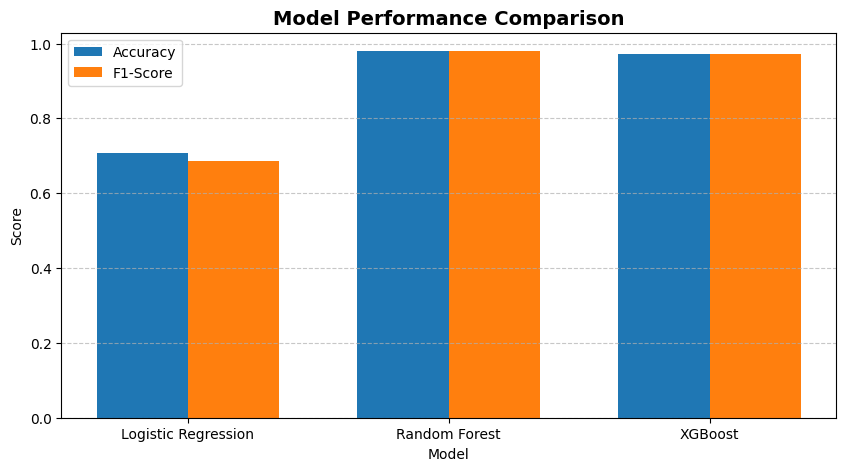

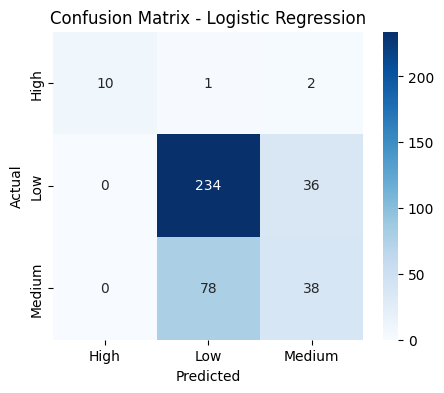

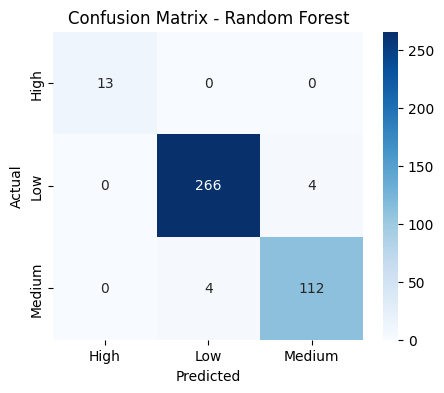

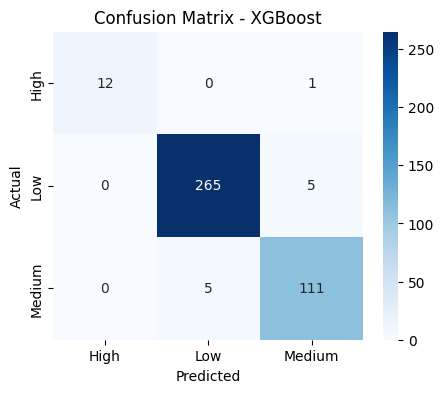

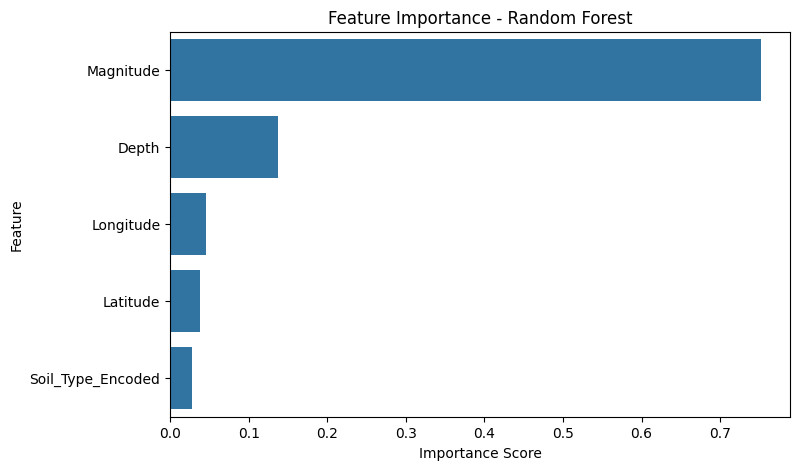

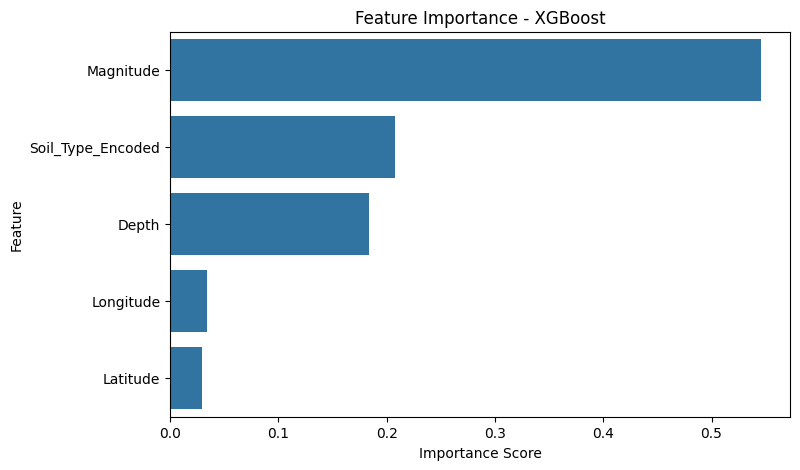

NameError: name 'roc_curve' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
'''
# ------------------------------
# Step 9: Model Visualization
# ------------------------------

# 1️⃣ Accuracy & F1-Score Comparison
metrics_df = results_df.reset_index().rename(columns={'index': 'Model'})
plt.figure(figsize=(10, 5))
bar_width = 0.35
x = np.arange(len(metrics_df['Model']))
plt.bar(x - bar_width/2, metrics_df['Accuracy'], width=bar_width, label='Accuracy')
plt.bar(x + bar_width/2, metrics_df['F1-Score'], width=bar_width, label='F1-Score')
plt.title("Model Performance Comparison", fontsize=14, fontweight='bold')
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(x, metrics_df['Model'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2️⃣ Confusion Matrix for Each Model
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# 3️⃣ Feature Importance (Random Forest & XGBoost)
feature_names = X_train.columns

if 'Random Forest' in models:
    importances = models['Random Forest'].feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importances[sorted_idx], y=np.array(feature_names)[sorted_idx])
    plt.title("Feature Importance - Random Forest")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()

if 'XGBoost' in models:
    importances = models['XGBoost'].feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importances[sorted_idx], y=np.array(feature_names)[sorted_idx])
    plt.title("Feature Importance - XGBoost")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()

# 4️⃣ ROC-AUC Comparison (for models with predict_proba)
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)
        if y_proba.shape[1] > 2:  # multi-class
            y_test_bin = pd.get_dummies(y_test)
            for i, class_name in enumerate(le.classes_):
                fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{name} - {class_name} (AUC = {roc_auc:.2f})")
        else:  # binary
            fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC-AUC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

'''